In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./result/online-retail-clean.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   main_idx     397884 non-null  int64  
 1   InvoiceNo    397884 non-null  int64  
 2   StockCode    397884 non-null  object 
 3   Description  397884 non-null  object 
 4   Quantity     397884 non-null  int64  
 5   InvoiceDate  397884 non-null  object 
 6   UnitPrice    397884 non-null  float64
 7   CustomerID   397884 non-null  float64
 8   Country      397884 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 27.3+ MB
None


,main_idx,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Add TotalSales

df['TotalSales'] = df['Quantity'] * df['UnitPrice']

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['date'] = pd.DatetimeIndex(df['InvoiceDate']).date
df['date'] = pd.to_datetime(df['date'])
# Time splitting
n_days = 90
max_date = df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

temp_in = df[df['InvoiceDate'] <= cutoff]
temp_out = df[df['InvoiceDate'] > cutoff]

In [5]:
temp_out['TotalSales'].sum()

3456002.722

In [6]:
df[df['InvoiceDate'] > cutoff]

,main_idx,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,date
236358,236358,566225,22384,LUNCH BAG PINK POLKADOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,9.90,2011-09-11
236359,236359,566225,20725,LUNCH BAG RED RETROSPOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,9.90,2011-09-11
236360,236360,566225,23169,CLASSIC GLASS COOKIE JAR,3,2011-09-11 10:35:00,4.15,16899.0,United Kingdom,12.45,2011-09-11
236361,236361,566225,84029E,RED WOOLLY HOTTIE WHITE HEART.,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,12.75,2011-09-11
236362,236362,566225,21479,WHITE SKULL HOT WATER BOTTLE,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,12.75,2011-09-11
...,...,...,...,...,...,...,...,...,...,...,...
397879,397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09
397880,397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09
397881,397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09
397882,397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09


In [7]:
# Feature engienering (RFM)

targets = temp_out\
            .groupby('CustomerID')\
            .agg({'TotalSales': sum})\
            .rename({'TotalSales': 'spend_90_days'}, axis=1)\
            .assign(spend_90_days_flag = 1)

targets.head()

,spend_90_days,spend_90_days_flag
CustomerID,,
12347.0,1519.14,1
12348.0,310.00,1
12349.0,1757.55,1
12352.0,944.23,1
12356.0,58.35,1


In [8]:
# Recency
recency = temp_in[['CustomerID', 'date']]\
            .groupby('CustomerID')\
            .apply(lambda x: (max_date - x['date'].max()) / pd.to_timedelta(1, 'day'))\
            .to_frame()\
            .set_axis(['Recency'], axis=1)

recency.head()

,Recency
CustomerID,
12346.0,325.0
12347.0,129.0
12348.0,248.0
12350.0,310.0
12352.0,262.0


In [9]:
# Frequency
frequency = temp_in[['CustomerID', 'date']]\
            .groupby('CustomerID')\
            .count()\
            .set_axis(['Frequency'], axis=1)

frequency.head()

,Frequency
CustomerID,
12346.0,1
12347.0,124
12348.0,28
12350.0,17
12352.0,38


In [10]:
# Monetary

monetary = temp_in\
            .groupby('CustomerID')\
            .agg({'TotalSales': ['sum']})\
            .set_axis(['Monetary'], axis=1)

monetary.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,2790.86
12348.0,1487.24
12350.0,334.40
12352.0,1561.81


In [11]:
# Create variables model

variables = pd.concat([recency, frequency, monetary], axis=1)\
            .merge(targets,
                  left_index=True,
                  right_index=True,
                  how='left')\
            .fillna(0)

variables.head()

,Recency,Frequency,Monetary,spend_90_days,spend_90_days_flag
CustomerID,,,,,
12346.0,325.0,1,77183.60,0.00,0.0
12347.0,129.0,124,2790.86,1519.14,1.0
12348.0,248.0,28,1487.24,310.00,1.0
12350.0,310.0,17,334.40,0.00,0.0
12352.0,262.0,38,1561.81,944.23,1.0


In [12]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

targets = ['spend_90_days', 'spend_90_days_flag']

X = variables.drop(targets, axis=1)
# scaler = StandardScaler()
# X_columns = X.columns
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=X_columns)
# Regression
y_spending = variables['spend_90_days']
# Classification
y_prob = variables['spend_90_days_flag']

In [48]:
# # ML for Regression
# xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# xgb_reg_model = GridSearchCV(estimator=xgb_reg,
#                             param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
#                             scoring='neg_mean_absolute_error',
#                             refit=True,
#                             cv=5)

# xgb_reg_model.fit(X, y_spending)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [49]:
# import pickle
# # Save the model to a file
# with open('./model/xgb_regression_model.pkl', 'wb') as model_file:
#     pickle.dump(xgb_reg_model, model_file)

In [50]:
with open('./model/xgb_regression_model.pkl', 'rb') as model_file:
    xgb_reg_model = pickle.load(model_file)

xgb_reg_model

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [51]:
print("Best score: ", xgb_reg_model.best_score_)
print("Best params: ", xgb_reg_model.best_params_)
print("Best estimator: \n", xgb_reg_model.best_estimator_)

predictions_reg = xgb_reg_model.predict(X_scaler)

Best score:  -694.9221513347198
Best params:  {'learning_rate': 0.01}
Best estimator: 
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


In [ ]:
# # ML for classification
# xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# xgb_clf_model = GridSearchCV(estimator=xgb_clf,
#                             param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
#                             scoring='roc_auc',
#                             refit=True,
#                             cv=5)
# xgb_clf_model.fit(X, y_prob)

In [ ]:
# import pickle
# # Save the model to a file
# with open('./model/xgb_clustering_model.pkl', 'wb') as model_file:
#     pickle.dump(xgb_clf_model, model_file)

In [23]:
with open('./model/xgb_clustering_model.pkl', 'rb') as model_file:
    xgb_clf_model = pickle.load(model_file)

xgb_clf_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [24]:
print("Best score: ", xgb_clf_model.best_score_)
print("Best params: ", xgb_clf_model.best_params_)
print("Best estimator: \n", xgb_clf_model.best_estimator_)

predictions_clf = xgb_clf_model.predict_proba(X)

Best score:  0.7252574475703522
Best params:  {'learning_rate': 0.01}
Best estimator: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


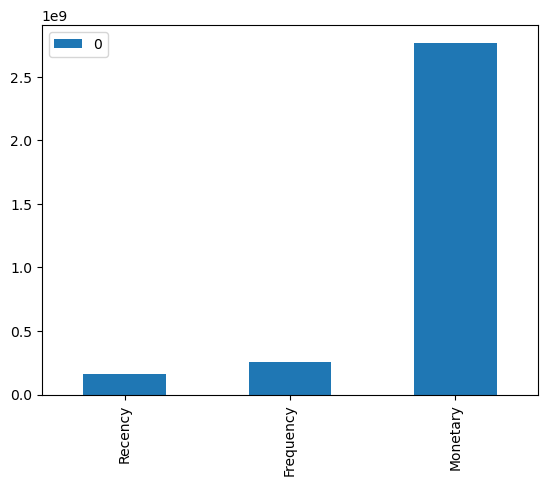

In [52]:
# Feature important (regression)

imp_feat_reg = xgb_reg_model\
                .best_estimator_\
                .get_booster()\
                .get_score(importance_type='gain')

pd.DataFrame.from_dict(imp_feat_reg, orient='index').plot(kind='bar')
plt.show()

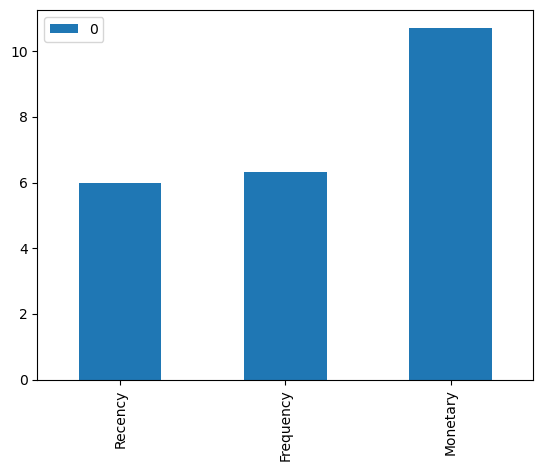

In [53]:
# Feature important (classification)

imp_feat_clf = xgb_clf_model\
                .best_estimator_\
                .get_booster()\
                .get_score(importance_type='gain')

pd.DataFrame.from_dict(imp_feat_clf, orient='index').plot(kind='bar')
plt.show()

In [34]:
with open('./model/kmeans_clustering_model.pkl', 'rb') as model_file:
    kmeans = pickle.load(model_file)

kmeans

KMeans(n_clusters=3, random_state=1)

In [35]:
with open('./model/kmeans_clustering_scaler.pkl', 'rb') as model_file:
    scaler = pickle.load(model_file)

scaler

StandardScaler()

In [36]:
rfm_table = variables[['Recency', 'Frequency', 'Monetary']]
rfm_table_scaled = scaler.transform(rfm_table)
rfm_table_scaled = pd.DataFrame(rfm_table_scaled, columns = rfm_table.columns, index = rfm_table.index)

rfm_table_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.369150,-0.422529,9.004379
12347.0,0.380642,16.172535,0.100251
12348.0,1.587951,3.220290,-0.055780
12350.0,2.216968,1.736178,-0.193764
12352.0,1.729987,4.569482,-0.046855


In [37]:
#create rfm segmentation table
rfm_segmentation = rfm_table.copy()
rfm_segmentation['Cluster'] = kmeans.predict(rfm_table_scaled)
rfm_segmentation = rfm_segmentation.reset_index()
rfm_segmentation.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325.0,1,77183.60,0
1,12347.0,129.0,124,2790.86,2
2,12348.0,248.0,28,1487.24,0
3,12350.0,310.0,17,334.40,0
4,12352.0,262.0,38,1561.81,0


In [38]:
variables

,Recency,Frequency,Monetary,spend_90_days,spend_90_days_flag
CustomerID,,,,,
12346.0,325.0,1,77183.60,0.00,0.0
12347.0,129.0,124,2790.86,1519.14,1.0
12348.0,248.0,28,1487.24,310.00,1.0
12350.0,310.0,17,334.40,0.00,0.0
12352.0,262.0,38,1561.81,944.23,1.0
...,...,...,...,...,...
18280.0,277.0,10,180.60,0.00,0.0
18281.0,180.0,7,80.82,0.00,0.0
18282.0,126.0,7,100.21,77.84,1.0


In [40]:
df_predictions = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        variables.reset_index()
    ],
    axis=1
)

df_predictions = df_predictions.merge(rfm_segmentation[['CustomerID', 'Cluster']], how='left', on='CustomerID')

df_predictions.head()

,pred_spend,pred_prob,CustomerID,Recency,Frequency,Monetary,spend_90_days,spend_90_days_flag,Cluster
0,0.235517,0.259587,12346.0,325.0,1,77183.60,0.00,0.0,0
1,686.815186,0.746531,12347.0,129.0,124,2790.86,1519.14,1.0,2
2,350.689301,0.646738,12348.0,248.0,28,1487.24,310.00,1.0,0
3,141.214371,0.330446,12350.0,310.0,17,334.40,0.00,0.0,0
4,429.105896,0.571859,12352.0,262.0,38,1561.81,944.23,1.0,0


In [ ]:
# df_predictions.to_csv('./result/customer-potential.csv', index=False)

In [62]:
variables.drop('spend_90_days_flag', axis=1).corr()

,Recency,Frequency,Monetary,spend_90_days
Recency,1.000000,-0.253969,-0.161749,-0.104583
Frequency,-0.253969,1.000000,0.453860,0.283534
Monetary,-0.161749,0.453860,1.000000,0.651296
spend_90_days,-0.104583,0.283534,0.651296,1.000000


In [63]:
variables.drop('spend_90_days_flag', axis=1).describe()

,Recency,Frequency,Monetary,spend_90_days
count,3370.000000,3370.000000,3370.000000,3370.000000
mean,184.998220,70.135905,1618.814594,846.253208
std,79.991369,147.805757,6151.394333,5007.291999
min,91.000000,1.000000,2.900000,0.000000
25%,116.000000,15.000000,266.100000,0.000000
50%,164.000000,33.000000,565.960000,173.815000
75%,241.750000,77.000000,1388.937500,689.870000
max,373.000000,4490.000000,178302.620000,168469.600000


In [66]:
df_predictions.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].describe().T

Cluster                     0             1              2
Recency   count   1188.000000   1317.000000     865.000000
          mean     268.002525    142.864844     135.149133
          std       61.639951     41.222282      49.748206
          min      134.000000     91.000000      91.000000
          25%      217.000000    109.000000      99.000000
          50%      264.000000    134.000000     119.000000
          75%      315.250000    170.000000     152.000000
          max      373.000000    313.000000     373.000000
Frequency count   1188.000000   1317.000000     865.000000
          mean      16.464646     36.667426     194.805780
          std       13.060597     19.867960     251.240762
          min        1.000000      1.000000      56.000000
          25%        7.000000     21.000000      97.000000
          50%       14.000000     35.000000     134.000000
          75%       22.000000     52.000000     205.000000
          max       77.000000     77.000000    4490.000000
Monetary  count   1188.000000   1317.000000     865.000000
          mean     482.895160    857.071952    4338.684360
          std     2837.986474   1069.710737   11165.813160
          min        2.900000     15.000000     233.810000
          25%      152.385000    329.670000    1339.370000
          50%      252.920000    613.670000    2112.060000
          75%      400.747500    998.050000    3595.710000
          max    77183.600000  15619.600000  178302.620000